In [25]:
# transformer plus a simple equations: learning some wave rules
import torch
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.nn import functional as F
from wavefn import WaveFunction

batch_size = 8
block_size = 32
max_iter = 10000
epochs = 10
eval_interval = 500
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embed = 16
n_head = 4
n_layer = 8
dropout = 0.1
text = []

# tokens set as integers
tokens = ['F1', 'F2', 'F3', 'F4', 's', 'e', '_', 'M', 'H', 'B']

# Example usage
wave_length = 32

# Let's make some waves! Not strictly needed, but repurposing the wave fn so keeping it for now
c = 1.0  # Wave speed
dx = 0.1  # Spatial step size
dt = 0.1  # Time step size
wave_fn = WaveFunction(c, dx, dt)

vocab_size=len(tokens)
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
def enc(s, pad_length):
    encoded = [stoi['s']] + [stoi[ch] for ch in s if ch in stoi] + [stoi['e']]
    padding = [stoi['_']] * (pad_length - len(encoded))  # Padding token is '_'
    return encoded + padding[:max(0, pad_length - len(encoded))]  # Ensures the sequence is exactly pad_length long
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')
# Define an appropriate size for your validation batch
val_batch_size = batch_size  

# Function to generate a random initial wave profile
def generate_random_wave_profile(size):
    return (np.random.rand(size)*10).astype(int)

# Function to simulate wave sequence
def simulate_wave_sequence(batch_size, size):
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    final_profiles = []
    for profile in initial_profiles:
        # Adjusted to capture the transformed profile correctly
        _, transformed_profile = wave_fn.simulate_wave_equation(profile)
        transformed_profile_clipped = np.clip(transformed_profile, 0, 9).astype(int)
        # Convert numpy array to list of strings
        transformed_profile_as_str_list = ['s'] + [str(num) for num in transformed_profile_clipped.tolist()] + ['e']
        final_profiles.append(transformed_profile_as_str_list)
    return initial_profiles, final_profiles

def generate_operation_sequence():
    # For simplicity, using a fixed sequence here. This could be randomized.
    return ['s', 'F1', 'F2', 'F3', 'F4', 'e']

def generate_operation_sequence_with_objective(block_size):
    objective = random.choice(['M', 'H', 'B'])
    if objective == 'M':
        sequence = ['F1', '_', '_', 'F4']
    elif objective == 'H':
        sequence = ['_', 'F2', 'F3', '_']
    else:  # B includes all operations
        sequence = ['F1', 'F2', 'F3', 'F4']

    # Ensure the sequence length does not exceed block size - 2 for start/end tokens
    sequence = sequence[:block_size - 2]
    return ['s'] + [objective] + sequence + ['e']

def apply_operations_sequence_to_wave(sequence, initial_wave):
    wave_fn = WaveFunction()
    current_profile = np.array(initial_wave, dtype=int)
    operations_map = {
        'F1': wave_fn.F1, 'F2': wave_fn.F2, 'F3': wave_fn.F3, 'F4': wave_fn.F4,
        '_': lambda x: x  # No-operation function returns the input as is
    }
    
    # Start applying transformations after the objective; skip '_'
    for op in sequence[1:]:  # Skip the 'objective' token
        if op in operations_map:  # Check if operation is defined in the map
            current_profile = operations_map[op](current_profile)
    
    return current_profile

def get_batch(batch_size, size, block_size):
    operations = [generate_operation_sequence_with_objective(block_size) for _ in range(batch_size)]
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    
    # Generate the expected outcomes by applying the operations
    final_profiles = []
    for ops, initial in zip(operations, initial_profiles):
        # Apply the operations sequence to the initial profile
        transformed_profile = apply_operations_sequence_to_wave(ops[1:-1], initial)  # Skip 's' and 'e'
        # Ensure the transformed profile is of consistent size, clip if necessary
        if len(transformed_profile) > block_size:
            transformed_profile = transformed_profile[:block_size]
        elif len(transformed_profile) < block_size:
            # Pad with zeros (or another padding strategy) if necessary
            transformed_profile = np.pad(transformed_profile, (0, block_size - len(transformed_profile)), 'constant', constant_values=(0,))
        final_profiles.append(transformed_profile)

    # Ensure no indices are created that exceed vocab_size - 1
    X = torch.tensor([enc(ops, block_size) for ops in operations], dtype=torch.long).to(device)
    # Make sure all elements in Y are within the valid range of indices
    Y = torch.tensor(final_profiles, dtype=torch.long).clamp(max=vocab_size-1).to(device)

    return X, Y

# single head attention
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed,head_size,bias=False)
        self.query = nn.Linear(n_embed,head_size,bias=False)
        self.value = nn.Linear(n_embed,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) *C**-0.5 # scaled attention
        # wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) # decoder block
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei@v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed,n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out) # Projection si the linear transformation of the outcome of prev layer
        return out

class SinusoidalActivation(nn.Module):
    def forward(self, x):
        # return torch.sin(x)
        return x + torch.sin(x) ** 2

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed,4* n_embed), 
            nn.GELU(),
            # SinusoidalActivation(),
            nn.Linear(4* n_embed, n_embed),
            nn.Dropout(dropout),
            )
        self

    def forward(self,x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed //n_head
        self.sa = MultiHeadAttention(n_head,head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self,x):
        attn_output = self.sa(self.ln1(x))
        x = x + attn_output  # add & norm for attention
        ffwd_output = self.ffwd(self.ln2(x))
        x = x + ffwd_output  # add & norm for feedforward
        return x

# bigram language model
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size,n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed,n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed,vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets=None):
        B,T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device))
        x = tok_emb+pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        # print(f"logits are shape {logits.shape} are: {logits} for idx: {idx}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(-1, vocab_size)  # Reshape logits to [batch_size * block_size, vocab_size]
            targets = targets.view(-1)  # Flatten targets to [batch_size * block_size]
            # targets = targets.view(-1, vocab_size)  # For MSE might need this encording.
            loss = F.cross_entropy(logits, targets) 
            # loss = F.mse_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # loss = F.l1_loss(logits, F.one_hot(targets, num_classes=vocab_size).float())
            # print(f"logits are shape {logits.shape} are: {loss} for idx: {idx}")
        return logits, loss
    
    def generate(self,idx,max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx=torch.cat((idx, idx_next), dim = 1)
        return idx

def apply_predicted_operations(predicted_operations, initial_wave):
    wave_fn = WaveFunction()
    current_profile = np.array(initial_wave, dtype=int)
    operations_map = {'F1': wave_fn.F1, 'F2': wave_fn.F2, 'F3': wave_fn.F3, 'F4': wave_fn.F4}
    
    for op in predicted_operations:
        if op in operations_map:
            current_profile = operations_map[op](current_profile)
    
    return current_profile

model = LanguageModel()
m = model.to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.5, centered=False)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
loss = None  # Initialize loss variable outside the loop

for epoch in range(epochs):
    for iter in range(max_iter // epochs):  # Distribute iterations across epochs
        model.train()
        xb, yb = get_batch(batch_size, wave_length, block_size)
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        max_norm = 1
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        if iter % eval_interval == 0 and loss is not None:  # Validation logic
            model.eval()
            with torch.no_grad():
                xv, yv = get_batch(val_batch_size, wave_length, block_size)
                val_logits, val_loss = model(xv, yv)
                print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
            model.train()

    scheduler.step(val_loss)  # Update the learning rate at the end of each epoch

torch.save(model, 'models/cat_wavefn_model.pth')

Epoch 0, Iteration 0: Training Loss = 2.309128522872925, Validation Loss = 2.2878642082214355
Epoch 0, Iteration 500: Training Loss = 1.6011003255844116, Validation Loss = 1.5353809595108032
Epoch 1, Iteration 0: Training Loss = 1.458828091621399, Validation Loss = 1.3675872087478638
Epoch 1, Iteration 500: Training Loss = 1.2630484104156494, Validation Loss = 1.4824858903884888
Epoch 2, Iteration 0: Training Loss = 1.361511468887329, Validation Loss = 1.3137671947479248


Initial Wave Profile: [8 6 9 6 1 4 5 5 5 8 2 7 2 8 6 2 1 3 4 5 8 5 3 9 8 6 0 9 4 1 9 5]
Objective wave output is: [5 9 9 9 9 9 9 2 2 5 9 9 9 9 2 9 9 9 2 0 0 5 9 9 9 9 9 9 5 9 5 5]
Predicted operations are: ['F3']
Transformed wave is: [7 5 9 5 0 3 4 4 4 7 1 6 1 7 5 1 0 2 3 4 7 4 2 9 7 5 0 9 3 0 9 4]


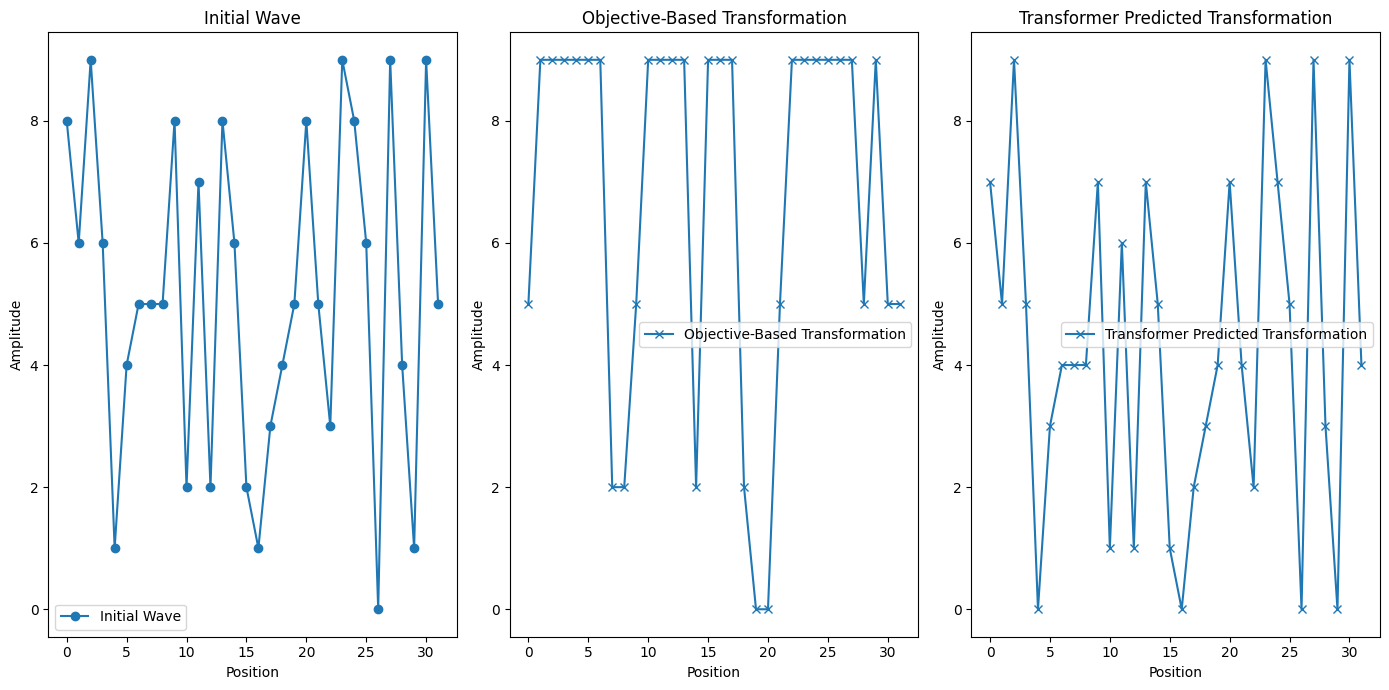

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from wavefn import WaveFunction

# Setting up the environment
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained model and set it to evaluation mode
model = torch.load('models/cat_wavefn_model.pth', map_location=device)
model.eval()

# Initialize the WaveFunction class
wave_fn = WaveFunction()

# Define the encoder and decoder for tokens
tokens = ['F1', 'F2', 'F3', 'F4', 's', 'e', '_', 'M', 'H', 'B']
stoi = {ch: i for i, ch in enumerate(tokens)}
itos = {i: ch for i, ch in enumerate(tokens)}

# Generate a random initial wave profile
input_length = 32
initial_wave = (np.random.rand(input_length) * 10).astype(int)
print(f"Initial Wave Profile: {initial_wave}")

# Prepare the model input (assuming the model takes numerical input)
initial_conditions = ['M']  # Let's say 'M' represents a type of condition or operation sequence
input_tensor = torch.tensor([[stoi[ch] for ch in initial_conditions]], dtype=torch.long).to(device)

# Predict operations
with torch.no_grad():
    output = model(input_tensor)
    logits = output if not isinstance(output, tuple) else output[0]  # Check if output is a tuple
    predicted_indices = logits.argmax(dim=-1)
    predicted_operations = [itos[int(idx)] for idx in predicted_indices[0]]

# Compare with direct simulation from WaveFunction using an objective
objective_wave_output = wave_fn.simulate_wave_equation(initial_wave, objective='B')
print(f"Objective wave output is: {objective_wave_output}")

print(f"Predicted operations are: {predicted_operations}")
transformed_wave = wave_fn.custom_transform(initial_wave, predicted_operations)
print(f"Transformed wave is: {transformed_wave}")

# Plotting results
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.plot(initial_wave, label='Initial Wave', marker='o')
plt.title('Initial Wave')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(objective_wave_output, label='Objective-Based Transformation', marker='x')
plt.title('Objective-Based Transformation')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(transformed_wave, label='Transformer Predicted Transformation', marker='x')
plt.title('Transformer Predicted Transformation')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()
